# RNN Controller Implementation and Testing


## Build controller
We are testing a simple language DAG:

| How | What | Why | --> | are | is | --> | I | you | it | --> | doing | going | coming |

An agent acts like, 
- "how are you doing"=5, 
- "how is it going"=4, 
- "what are you doing"=2, "what is it doing"=2, "why are you going"=2
- all others=-1

First define the controller class:

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from General_Controller import *
controller=GeneralController()

s = tf.Session()
s.run(tf.global_variables_initializer())
sample_arc = s.run(controller.sample_arc)
feed_dict={"arc_{}:0".format(i):sample_arc[i] for i in range(controller.total_arc_len)}
feed_dict[controller.reward] = 100.

--------------------------------------------------------------------------------
Building ConvController
--------------------------------------------------------------------------------
Build controller sampler
--------------------------------------------------------------------------------
Build controller trainer
--------------------------------------------------------------------------------
<tf.Variable 'controller/lstm/lstm_layer_0/w:0' shape=(64, 128) dtype=float32_ref>
<tf.Variable 'controller/lstm/lstm_layer_1/w:0' shape=(64, 128) dtype=float32_ref>
<tf.Variable 'controller/g_emb:0' shape=(1, 32) dtype=float32_ref>
<tf.Variable 'controller/emb/layer_0/w_start:0' shape=(3, 32) dtype=float32_ref>
<tf.Variable 'controller/emb/layer_0/w_count:0' shape=(2, 32) dtype=float32_ref>
<tf.Variable 'controller/emb/layer_1/w_start:0' shape=(2, 32) dtype=float32_ref>
<tf.Variable 'controller/emb/layer_1/w_count:0' shape=(1, 32) dtype=float32_ref>
<tf.Variable 'controller/emb/layer_2/w_start:

Above prints out all trainable tensors for controller.

If sampling 2 operations (start + count) on each layer:

    layer 5 branch 1: 20 = 2 + 3 + 4 + 5 + 6

    layer 4 branch 1: 14 = 2 + 3 + 4 + 5

    layer 3 branch 1: 9 = 2 + 3 + 4

    layer 2 branch 1: 5 = 2 + 3

If sampling 1 operation on each layer:

    layer 4 branch 1: 10 = 1 + 2 + 3 + 4
    
    layer 3 branch 1: 6 = 1 + 2 + 3

    layer 2 branch 1: 3 = 1 + 2

Next we randomly sampled a one-hot architecture sequence, then train it 200 times, to make sure the training is working.

In [2]:
print(s.run(controller.onehot_log_prob, feed_dict=feed_dict))
for _ in range(200):
	s.run(controller.train_op, feed_dict = feed_dict )

print(s.run(controller.onehot_log_prob, feed_dict=feed_dict))

8.14814
0.26225373


In [3]:
print(sample_arc)
print(s.run(controller.sample_arc))

[2 0 0 1 1 1 0 1 1 0]
[2 0 0 1 1 1 0 1 1 0]


In [4]:
s.close()

## Connect with agent

The Agent emulates the language scenario depicted at the very beginning.

In [5]:
from Agent import *
dag = build_dag()
for _ in range(5):
    print(dag.get_random_model_states())

['How', 'are', 'I', 'doing']
['How', 'are', 'I', 'going']
['What', 'is', 'I', 'coming']
['Why', 'is', 'it', 'doing']
['What', 'is', 'you', 'coming']


In [6]:
agent = Agent(dag, default_score = -1.)
agent.alter_path_score('How is it going', 4.)
agent.alter_path_score('How are you doing', 5.)
agent.alter_path_score('What are you doing', 2.)
agent.alter_path_score('What is it doing', 2.)
agent.alter_path_score('Why are you going', 2.)

In [7]:
agent.get_reward('How are you doing')

5.0

In [8]:
print(agent.decode_arc_seq(sample_arc), agent.get_reward(agent.decode_arc_seq(sample_arc))) 

Why are you doing -1.0


## Training
Training by providing values to feed_dict.

In [9]:
t = tf.Session()
#t.run(tf.set_random_seed(1))
t.run(tf.global_variables_initializer())
ewa_reward = 0.
buffer = []
for i in range(1500):
    if i and i%150==0:
        print(agent.decode_arc_seq(buffer[-1][0]), ewa_reward)
    arc = t.run(controller.sample_arc)
    reward = agent.get_reward(agent.decode_arc_seq(arc))
    feed_dict={"arc_{}:0".format(i):arc[i] for i in range(controller.total_arc_len)}
    feed_dict[controller.reward] = reward
    t.run(controller.train_op, feed_dict = feed_dict)
    ewa_reward = 0.8*ewa_reward + 0.2*reward
    buffer.append( (arc, reward) )

Why is you coming -0.9629505702227958
How is you doing -0.9110569763081326
How are you doing 0.3075094423039709
Why is you doing -0.5199750381795547
How are you coming -0.9991793227984813
What are you coming -0.995771979731771
What is you doing -0.5042092173937867
How are you doing 3.473414344588296
How are you doing 4.934380079258098


## Understand Controller behaviors

First examine the converged sentence:

In [10]:
idx = [i for i in range(len(buffer)) if buffer[i][1]>=0]
print(len(idx))
for i in range(1, 200, 20):
    print(idx[-i], agent.decode_arc_seq(buffer[idx[-i]][0]), buffer[idx[-i]][1])
    #print(agent.decode_arc_seq(buffer[-i][0]), buffer[-i][1])

522
1499 What are you doing 2.0
1479 How are you doing 5.0
1459 How are you doing 5.0
1438 How are you doing 5.0
1418 How are you doing 5.0
1398 How are you doing 5.0
1378 How are you doing 5.0
1357 How are you doing 5.0
1337 How are you doing 5.0
1317 How are you doing 5.0


Next, plot the reward of sampled actions over time steps. After 1000 steps, it started to sampling on less diverged actions.

Text(0,0.5,'SMA Reward')

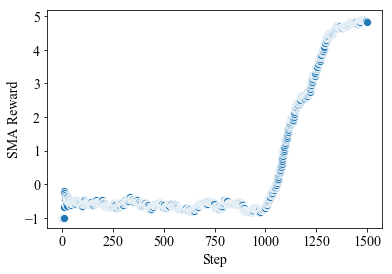

In [13]:
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from BioNAS.utils.plots import sma
sma_reward = sma([x[1] for x in buffer], window=100)
ax1 = sns.scatterplot(x=np.arange(len(buffer)), y=sma_reward)
ax1.set_xlabel('Step')
ax1.set_ylabel('SMA Reward')

The frequency of positive rewards are uniform before 1000; started to accumulated after 1000.

Text(0,0.5,'Positive Reward Frequency')

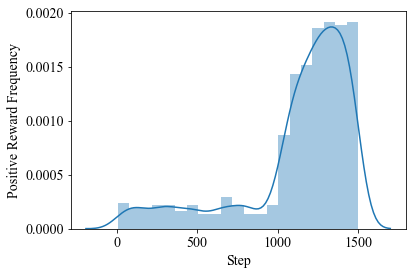

In [14]:
ax2 = sns.distplot(idx)
ax2.set_xlabel('Step')
ax2.set_ylabel('Positive Reward Frequency')